# Workshop: Análisis y Modelado de PUFs (Physical Unclonable Functions)
Este Notebook está dividido en dos partes:

1. **Análisis de Weak PUFs (SRAM/RO):** Evaluaremos la "calidad" de un PUF mediante métricas estadísticas.
2. **Ataques de Modelado (ML):** Intentaremos "clonar" un strong PUF (Arbiter PUF) usando Machine Learning y veremos cómo el diseño afecta su seguridad.


In [ ]:
# Instalamos la librería pypuf para simular arquitecturas complejas
!pip install pypuf
import numpy as np
import matplotlib.pyplot as plt
import pypuf.simulation
import pypuf.io
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
print("✅ Entorno configurado correctamente.")

✅ Entorno configurado correctamente.


Los datos vienen de las siguientes publicaciones:

**Vinagrero, Sergio, Honorio Martin, Alice De Bignicourt, Elena-Ioana Vatajelu, and Giorgio Di Natale. "Sram-based puf readouts." Scientific Data 10, no. 1 (2023): 333.**
El dataset esta disponible para descargar en https://zenodo.org/records/7529513

El dataset que vamos a utilizar aqui es un subset formado por 15 muestras de 1024 bits cada una de 42 dispositivos.

**Hesselbarth, Robert, Florian Wilde, Chongyan Gu, and Neil Hanley. "Large scale RO PUF analysis over slice type, evaluation time and temperature on 28nm Xilinx FPGAs." In 2018 IEEE International Symposium on Hardware Oriented Security and Trust (HOST), pp. 126-133. IEEE, 2018.**
El dataset esta disponible para descargar en https://github.com/Fraunhofer-AISEC/fpga-ro-data/tree/master

El dataset que vamos a utilizar aqui es un subset formado por 100 muestras de muestras de 512 bits cada una de 50 dispositivos. Los datos se han obtenido del fichero `LEFT-LOWER`

Los datos ya han sido procesados para poder trabajar directamente con ellos.


In [ ]:
sram_crps = np.load("sram_crps.npy")
# Muestras, bits, dispositivos
print(sram_crps.shape)

ro_countdiff = np.load("ro_countdiff.npy")
# Por regla general, differencias de frequencia (o del contador) positivas equivalen a una respuesta de '1' y '0' en caso contrario
ro_crps = np.where(ro_countdiff >= 0, 1, 0)
# Dispositivos, bits, muestras
print(ro_crps.shape)

(15, 1024, 42)
(50, 512, 100)


## Vistazo preliminar a los datos

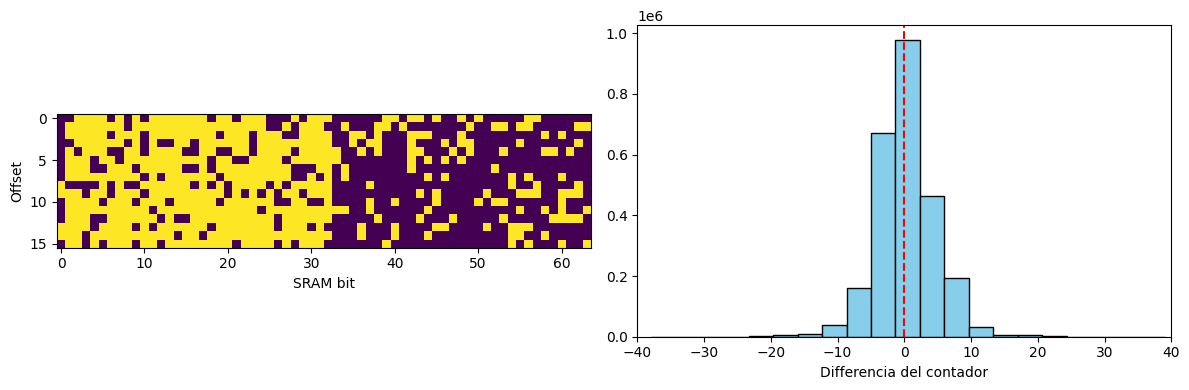

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(sram_crps[10,:,1].reshape(16, -1))
axs[0].set_xlabel("SRAM bit")
axs[0].set_ylabel("Offset")

axs[1].hist(ro_countdiff.ravel(), bins=21, color='skyblue', edgecolor='black')
axs[1].set_xlabel("Differencia del contador")
axs[1].axvline(0.0, color='red', linestyle='--')
axs[1].set(xlim=(-40, 40))

fig.tight_layout()
plt.show()

# Parte 1: Evaluación de Métricas de un weak PUF


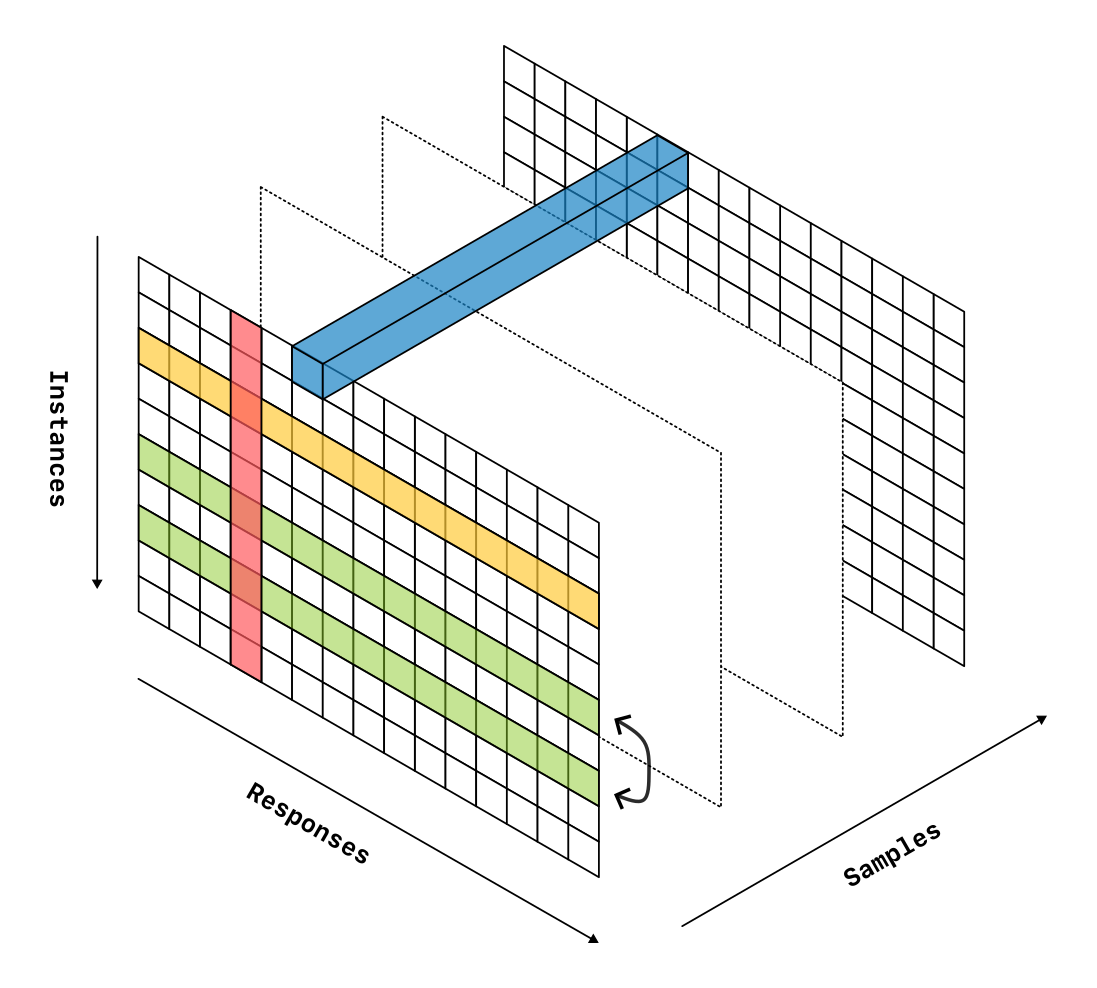

In [ ]:
# Las metricas Uniformity, Bit-aliasing y Reliability
# se pueden calcular facilmente con `np.mean`
# Sin embargo, tenemos que crear una funcion para calcular Uniqueness
def uniqueness(data):
    "Calcula la Uniqueness (Inter Hamming Distance)"
    distances = []
    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            dist = np.mean(data[i] != data[j])
            distances.append(dist)
    return np.array(distances)

## SRAM PUF


In [ ]:
muestras_sram = np.arange(sram_crps.shape[0])

sram_crps_avg = np.mean(sram_crps, axis=0)
# Respuestas obtenidas por majority voting
sram_ref = np.where(sram_crps_avg >= 0.5, 1, 0).T
sram_bit_matches = np.stack([sram_crps[i,:,:].T == sram_ref for i in muestras_sram], axis=2)

sram_uniformity = np.mean(sram_ref, axis=0)

sram_bitaliasing = np.mean(sram_ref, axis=1)

sram_uniqueness = uniqueness(sram_ref)

sram_reliability = np.mean(sram_bit_matches, axis=2).mean(axis=0)

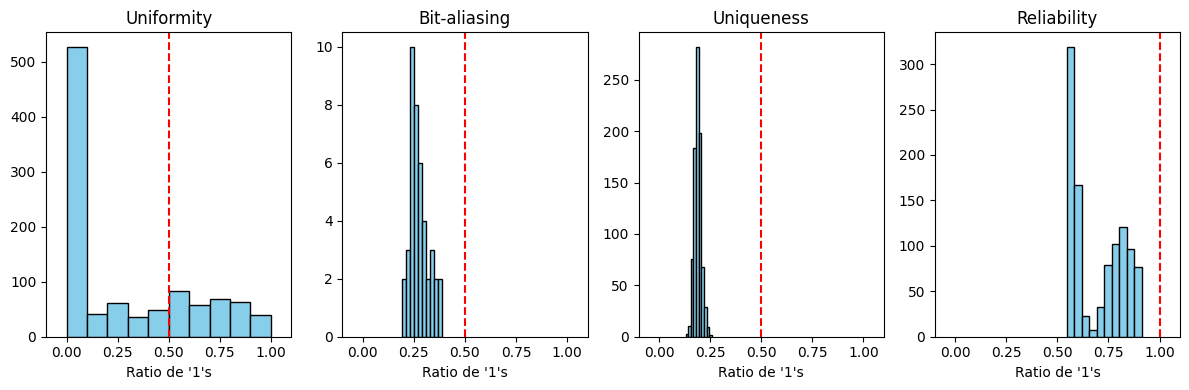

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].hist(sram_uniformity.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[0].set_title("Uniformity")
axs[0].set_xlabel("Ratio de '1's")
axs[0].axvline(0.5, color='red', linestyle='--')
axs[0].set(xlim=(-0.1, 1.1))

axs[1].hist(sram_bitaliasing.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[1].set_title("Bit-aliasing")
axs[1].set_xlabel("Ratio de '1's")
axs[1].axvline(0.5, color='red', linestyle='--')
axs[1].set(xlim=(-0.1, 1.1))

axs[2].hist(sram_uniqueness.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[2].set_title("Uniqueness")
axs[2].set_xlabel("Ratio de '1's")
axs[2].axvline(0.5, color='red', linestyle='--')
axs[2].set(xlim=(-0.1, 1.1))

axs[3].hist(sram_reliability.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[3].set_title("Reliability")
axs[3].set_xlabel("Ratio de '1's")
axs[3].axvline(1, color='red', linestyle='--')
axs[3].set(xlim=(-0.1, 1.1))

fig.tight_layout()
plt.show()

## Ring Oscillator PUF

In [ ]:
muestras_ro = np.arange(ro_crps.shape[2])

ro_crps_avg = np.mean(ro_crps, axis=2)
# Respuestas obtenidas por majority voting
ro_ref = np.where(ro_crps_avg >= 0.5, 1, 0)
ro_bit_matches = np.stack([ro_crps[:,:,i] == ro_ref for i in muestras_ro], axis=2)

ro_uniformity = np.mean(ro_ref, axis=1)

ro_bitaliasing = np.mean(ro_ref, axis=0)

ro_uniqueness = uniqueness(ro_ref)

ro_reliability = np.mean(ro_bit_matches, axis=2).mean(axis=0)

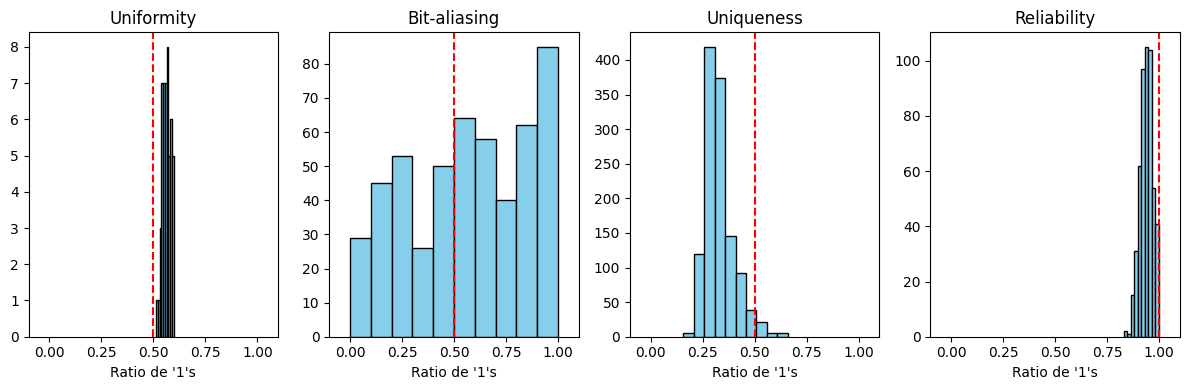

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].hist(ro_uniformity.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[0].set_title("Uniformity")
axs[0].set_xlabel("Ratio de '1's")
axs[0].axvline(0.5, color='red', linestyle='--')
axs[0].set(xlim=(-0.1, 1.1))

axs[1].hist(ro_bitaliasing.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[1].set_title("Bit-aliasing")
axs[1].set_xlabel("Ratio de '1's")
axs[1].axvline(0.5, color='red', linestyle='--')
axs[1].set(xlim=(-0.1, 1.1))

axs[2].hist(ro_uniqueness.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[2].set_title("Uniqueness")
axs[2].set_xlabel("Ratio de '1's")
axs[2].axvline(0.5, color='red', linestyle='--')
axs[2].set(xlim=(-0.1, 1.1))

axs[3].hist(ro_reliability.ravel(), bins=10, color='skyblue', edgecolor='black')
axs[3].set_title("Reliability")
axs[3].set_xlabel("Ratio de '1's")
axs[3].axvline(1, color='red', linestyle='--')
axs[3].set(xlim=(-0.1, 1.1))

fig.tight_layout()
plt.show()

## Relacion entre la diferencia de frequencia, Reliability y Bit-aliasing

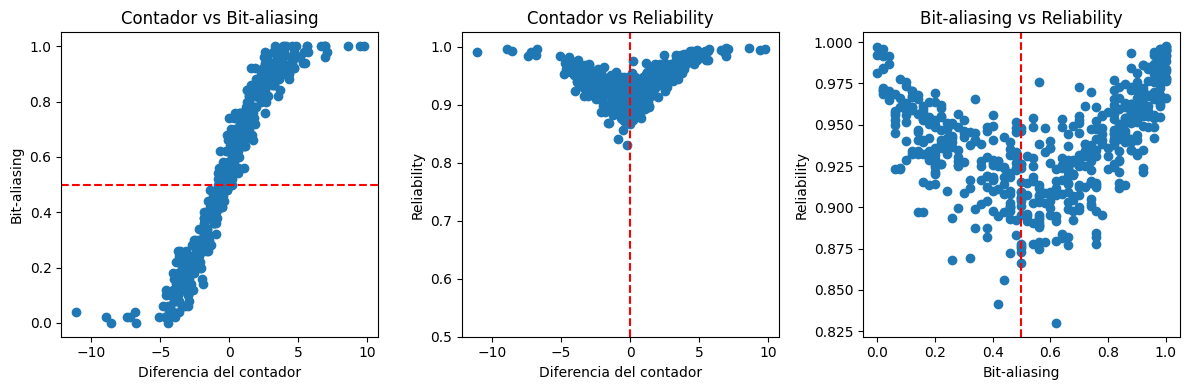

In [ ]:
ro_countdiff_avg = np.mean(ro_countdiff[:,:,0], axis=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(ro_countdiff_avg, ro_bitaliasing)
axs[0].set_title("Contador vs Bit-aliasing")
axs[0].set_xlabel("Diferencia del contador")
axs[0].set_ylabel("Bit-aliasing")
axs[0].axhline(0.5, color='red', linestyle='--')

axs[1].scatter(ro_countdiff_avg, ro_reliability)
axs[1].set_title("Contador vs Reliability")
axs[1].set_xlabel("Diferencia del contador")
axs[1].set_ylabel("Reliability")
axs[1].set(ylim=(0.5, 1.025))
axs[1].axvline(0, color='red', linestyle='--')

axs[2].scatter(ro_bitaliasing, ro_reliability)
axs[2].set_title("Bit-aliasing vs Reliability")
axs[2].set_xlabel("Bit-aliasing")
axs[2].set_ylabel("Reliability")
axs[1].set(ylim=(0.5, 1.025))
axs[2].axvline(0.5, color='red', linestyle='--')

fig.tight_layout()
plt.show()

# Parte 2: El Ataque de los Clones (Machine Learning)
Un **Arbiter PUF** es un strong PUF bastante simple. El problema es que su respuesta es una función lineal de los retardos ("delays") de sus celdas. Si un atacante recolecta suficientes CRPs, puede crear un modelo que prediga la respuesta de cualquier nuevo desafío.

Para evitar esto, vamos a explorar como el numero de etapas, numeros de muestras y diseño alternativos (en concreto el **XOR-Arbiter PUFs**) afectan a la capacidad de modelado.
Se podra ver que habra cambios que aumenten la seguridad, pero a cambio de hacer que el PUF sea mucho más sensible al ruido, o que los recursos usados aumenten exponencialmente.

Podeis cambiar los siguientes parametros:

* El numero de entradas de cada PUF (`n_bits`)
* El numero de muestras disponibles para el entrenamiento (`n_train`)
* El numero de Arbiter PUF en paralelo cuando useis el XORArbiterPUF (`k`)
  * Por ejemplo, si `k=4`, entonces el resultado final es el XOR de 4 respuestas de 4 ArbiterPUF distintas a las que se han aplicado las mismas entradas (Challenge)

El objetivo que contemplar como cambiando estos parametros podemos hacer que la predictibilidad se mantenga cerca del 50% mientras que comprobamos el numero de recursos totales usados (x numero de etapas)

In [ ]:
def run_attack_experiment(puf_type="Arbiter", n_bits=32, n_train=500, k=4):
    """
    Para el XORArbiterPUF, el parametro `k` indica cuentas ArbiterPUF se usan en paralelo. .
    """
    if puf_type == "Arbiter":
        puf = pypuf.simulation.ArbiterPUF(n=n_bits, seed=1)
    else:
        puf = pypuf.simulation.XORArbiterPUF(n=n_bits, k=k, seed=1)

    # Generar CRPs
    X_train = pypuf.io.random_inputs(n=n_bits, N=n_train, seed=2)
    y_train = puf.eval(X_train)

    X_test = pypuf.io.random_inputs(n=n_bits, N=1000, seed=3)
    y_test = puf.eval(X_test)

    # Creamos el modelo
    # model = LogisticRegression()
    model = SVC()
    model.fit(X_train, y_train)

    # Evaluamos la precisión
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Prueba a cambiar el 'n_train' (número de muestras) o el tipo de PUF
print("Atacando Arbiter PUF (8 bits)...")
acc_apuf = run_attack_experiment("Arbiter", n_bits=8, n_train=100)
print(f"Precisión del atacante: {acc_apuf*100:.2f}%")

print("\nAtacando Arbiter PUF (32 bits)...")
acc_apuf = run_attack_experiment("Arbiter", n_bits=32, n_train=500)
print(f"Precisión del atacante: {acc_apuf*100:.2f}%")

print("\nAtacando XOR-Arbiter PUF (k=4, 32 bits)...")
acc_xor = run_attack_experiment("XOR", n_bits=32, n_train=500, k=4)
print(f"Precisión del atacante: {acc_xor*100:.2f}%")

Atacando Arbiter PUF (8 bits)...
Precisión del atacante: 62.10%

Atacando Arbiter PUF (32 bits)...
Precisión del atacante: 51.10%

Atacando XOR-Arbiter PUF (k=4, 32 bits)...
Precisión del atacante: 51.10%
